## Imports

In [378]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
import squarify

sns.set(style="whitegrid")
%matplotlib inline

In [379]:
#bom_df = pd.read_csv('Data/bom.movie_gross.csv')
# imdb_name_df = pd.read_csv('Data/imdb.name.basics.csv')
# imdb_akas_df = pd.read_csv('Data/imdb.title.akas.csv')
# imdb_basics_df = pd.read_csv('Data/imdb.title.basics.csv')
# imbd_crew_df = pd.read_csv('Data/imdb.title.crew.csv')
# imdb_principals_df = pd.read_csv('Data/imdb.title.principals.csv')
# imdb_ratings_df = pd.read_csv('Data/imdb.title.ratings.csv')
# rt_info_df = pd.read_csv('Data/rt.movie_info.tsv', sep = '\t')
# rt_reviews_df = pd.read_csv('Data/rt.reviews.tsv', sep = '\t', encoding ='ISO-8859-1')
# tmdb_movies_df = pd.read_csv('Data/tmdb.movies.csv')
# tn_budgets_df = pd.read_csv('Data/tn.movie_budgets.csv')

tmdb_data = pd.read_csv('Data/tmdb_movies_data.csv')
oscars_data = pd.read_csv('Data/oscars_database.csv')

## Data Cleaning

#### Oscars Cleaning

In [380]:
oscars_data.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1927/1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1927/1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1927/1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1927/1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1927/1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson


In [381]:
oscars_data['Year'] = oscars_data['Year'].str[:4].astype('int64')
oscars_data = oscars_data[oscars_data['Year'] >= 2000]
oscars_data = oscars_data[oscars_data['Year'] <= 2019]
oscars_data.drop(columns = 'Ceremony', inplace = True)

In [382]:
oscars_data[oscars_data['Film'] == 'Avatar']

,Year,Award,Winner,Name,Film


In [383]:
oscars_data.isna().sum()

Year         0
Award        0
Winner    1458
Name         0
Film        72
dtype: int64

In [384]:
oscars_data = oscars_data[~oscars_data['Film'].isna()]
oscars_data = oscars_data.fillna(0)
oscars_data = oscars_data.set_index('Film')
oscars_data.sort_values('Film', inplace = True)
oscars_data.head()

,Year,Award,Winner,Name
Film,,,,
12 Years a Slave,2013,Actor in a Leading Role,0.0,Chiwetel Ejiofor
12 Years a Slave,2013,Actress in a Supporting Role,1.0,Lupita Nyong'o
12 Years a Slave,2013,Actor in a Supporting Role,0.0,Michael Fassbender
127 Hours,2010,Actor in a Leading Role,0.0,James Franco
21 Grams,2003,Actor in a Supporting Role,0.0,Benicio Del Toro


In [385]:
wins = oscars_data.groupby('Film').sum()['Winner']
nominations = oscars_data.groupby('Film').count()['Winner']

In [386]:
nominations.head()

Film
12 Years a Slave    3
127 Hours           1
21 Grams            2
45 Years            1
A Beautiful Mind    2
Name: Winner, dtype: int64

#### TMDB Cleaning

In [387]:
tmdb_data.columns

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

In [388]:
tmdb_data.drop(columns = ['id', 'homepage', 'tagline', 'keywords', 'overview', 'runtime', 'production_companies', 
                         'release_date'], inplace = True)

In [389]:
tmdb_data['cast'] = tmdb_data['cast'].apply(lambda x: str(x).split('|'))
tmdb_data['genres'] = tmdb_data['genres'].apply(lambda x: str(x).split('|'))


In [390]:
tmdb_cleaned = tmdb_data.sort_values(by = ['revenue_adj'], ascending = False)
tmdb_cleaned = tmdb_cleaned[~tmdb_cleaned.director.isna()]
tmdb_cleaned = tmdb_cleaned.drop_duplicates(subset ="imdb_id", keep = False)
tmdb_cleaned = tmdb_cleaned[tmdb_cleaned['release_year'] >= 2000]


In [391]:
tmdb_cleaned['budget'] = tmdb_data['budget']/1000000
tmdb_cleaned['revenue'] = tmdb_data['revenue']/1000000
tmdb_cleaned['budget_adj'] = tmdb_cleaned['budget_adj']/1000000
tmdb_cleaned['revenue_adj'] = tmdb_cleaned['revenue_adj']/1000000
tmdb_cleaned['profit'] = tmdb_cleaned['revenue_adj'] - tmdb_cleaned['budget_adj']

In [392]:
tmdb_cleaned[tmdb_cleaned['original_title'] == 'Avatar']

,imdb_id,popularity,budget,revenue,original_title,cast,director,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
1386,tt0499549,9.432768,237.0,2781.505847,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,"[Action, Adventure, Fantasy, Science Fiction]",8458,7.1,2009,240.886903,2827.12375,2586.236847


#### Merging Data Frames

In [393]:
merged_data = tmdb_cleaned

In [394]:
merged_data = merged_data.merge(nominations, left_on = 'original_title', right_on = 'Film', how = 'left')
merged_data.rename(columns = {'Winner': 'nominations'}, inplace = True)
merged_data = merged_data.merge(wins, left_on = 'original_title', right_on = 'Film', how = 'left')
merged_data.rename(columns = {'Winner': 'wins'}, inplace = True)
#merged_data.nominations.fillna(0, inplace = True)
#merged_data.wins.fillna(0, inplace = True)

quick note! we want to do a left merge here, because if we do only the intersection, we will get a small selection of movies that have been nominated to the oscars meaning the budgets and revenues will be much much higher!

In [395]:
merged_data.head()

,imdb_id,popularity,budget,revenue,original_title,cast,director,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,nominations,wins
0,tt0499549,9.432768,237.0,2781.505847,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,"[Action, Adventure, Fantasy, Science Fiction]",8458,7.1,2009,240.886903,2827.123750,2586.236847,NaN,NaN
1,tt2488496,11.173104,200.0,2068.178225,Star Wars: The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",J.J. Abrams,"[Action, Adventure, Science Fiction, Fantasy]",5292,7.5,2015,183.999919,1902.723130,1718.723211,NaN,NaN
2,tt0848228,7.637767,220.0,1519.557910,The Avengers,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Joss Whedon,"[Science Fiction, Action, Adventure]",8903,7.3,2012,208.943742,1443.191435,1234.247693,NaN,NaN
3,tt0369610,32.985763,150.0,1513.528810,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",Colin Trevorrow,"[Action, Adventure, Science Fiction, Thriller]",5562,6.5,2015,137.999939,1392.445893,1254.445954,NaN,NaN
4,tt2820852,9.335014,190.0,1506.249360,Furious 7,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",James Wan,"[Action, Crime, Thriller]",2947,7.3,2015,174.799923,1385.748801,1210.948878,NaN,NaN


## Feature Generation (Genres)

In [396]:
comedies = merged_data[merged_data['genres'].apply(lambda x: 'Comedy' in x)]
dramas = merged_data[merged_data['genres'].apply(lambda x: 'Drama' in x)]
horrors = merged_data[merged_data['genres'].apply(lambda x: 'Horror' in x)]
adventures = merged_data[merged_data['genres'].apply(lambda x: 'Adventure' in x)]
fantasies = merged_data[merged_data['genres'].apply(lambda x: 'Fantasy' in x)]
thrillers = merged_data[merged_data['genres'].apply(lambda x: 'Thriller' in x)]
science_fictions = merged_data[merged_data['genres'].apply(lambda x: 'Science Fiction' in x)]
actions = merged_data[merged_data['genres'].apply(lambda x: 'Action' in x)]
crimes = merged_data[merged_data['genres'].apply(lambda x: 'Crime' in x)]
families = merged_data[merged_data['genres'].apply(lambda x: 'Family' in x)]
animations = merged_data[merged_data['genres'].apply(lambda x: 'Animation' in x)]
mysteries = merged_data[merged_data['genres'].apply(lambda x: 'Mystery' in x)]

In [397]:
genres = [comedies, dramas, horrors, adventures, fantasies, thrillers, science_fictions, actions, crimes, families, animations, mysteries]
genres_names = ['comedy', 'drama', 'horror', 'adventure', 'fantasy', 'thriller', 'science fiction', 'action', 'crime', 'family', 'animation', 'mystery']

In [398]:
revenues_adj_mean = []
budget_adj_mean = []
oscar_nominations = []
oscar_wins = []
for genre in genres:
    revenues_adj_mean.append(genre.mean()['revenue_adj'])
    budget_adj_mean.append(genre.mean()['budget_adj'])
    oscar_nominations.append(genre.sum()['nominations'])
    oscar_wins.append(genre.sum()['wins'])

to_df = []
for i in range(len(genres_names)):
    my_list = [genres_names[i], budget_adj_mean[i], revenues_adj_mean[i], oscar_nominations[i], oscar_wins[i]]
    to_df.append(my_list)

genres_df = pd.DataFrame(to_df, columns = ['genre', 'budget', 'revenue', 'oscar_nominations', 'oscar_wins']) 

In [399]:
genres_df

,genre,budget,revenue,oscar_nominations,oscar_wins
0,comedy,16.878112,43.847863,45.0,7.0
1,drama,13.754486,30.100474,291.0,60.0
2,horror,6.924493,17.873654,3.0,1.0
3,adventure,52.896315,153.355885,14.0,2.0
4,fantasy,46.038945,138.644258,7.0,0.0
5,thriller,19.885447,43.716633,54.0,12.0
6,science fiction,32.986638,88.752090,3.0,0.0
7,action,36.729493,91.910526,22.0,5.0
8,crime,22.435637,48.033432,44.0,9.0
9,family,31.958533,95.348340,1.0,0.0


In [400]:
genres_df.sort_values(by = ['revenue'], inplace = True, ascending = False)
genres_df['profit'] = genres_df['revenue'] - genres_df['budget']

In [401]:
genres_df = genres_df.reset_index().drop(columns = ['index'])
genres_df.head()

,genre,budget,revenue,oscar_nominations,oscar_wins,profit
0,adventure,52.896315,153.355885,14.0,2.0,100.459571
1,fantasy,46.038945,138.644258,7.0,0.0,92.605313
2,family,31.958533,95.348340,1.0,0.0,63.389808
3,action,36.729493,91.910526,22.0,5.0,55.181033
4,science fiction,32.986638,88.752090,3.0,0.0,55.765451


## Analysis & Visualizations (Genres)

Text(0,0.5,'Mean Revenue in Millions of Dollars')

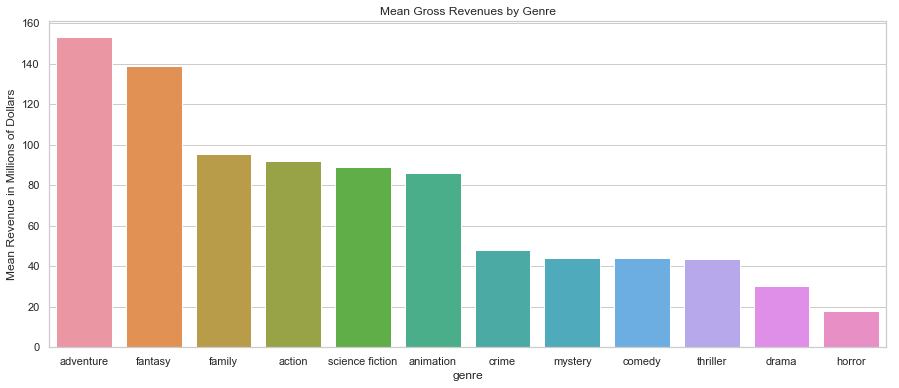

In [402]:
plt.figure(figsize = (15,6))
sns.barplot(x = 'genre', y = 'revenue', data = genres_df)
plt.title('Mean Gross Revenues by Genre')
plt.ylabel('Mean Revenue in Millions of Dollars')

Text(0,0.5,'Mean Profit in Millions of Dollars')

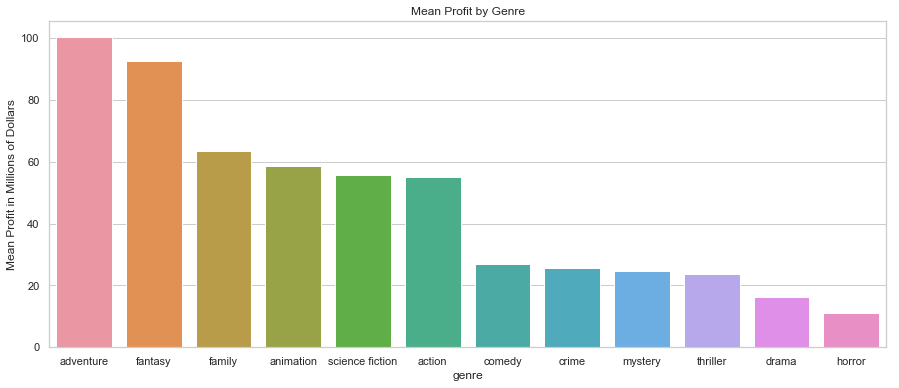

In [403]:
genres_df.sort_values(by = ['profit'], inplace = True, ascending = False)
plt.figure(figsize = (15,6))
sns.barplot(x = 'genre', y = 'profit', data = genres_df)
plt.title('Mean Profit by Genre')
plt.ylabel('Mean Profit in Millions of Dollars')

In [404]:
#plt.figure(figsize = (14,10))
#squarify.plot(sizes = genres_df['profit'], label = genres_df['genre'])

#### So it looks like we should go for adventure/fantasy, right? BUT WAIT! Microsoft wants a good film. It has a bunch of streaming content ready to go. Microsoft believes that the first film needs to make waves and gain attention for the platform, so we definitely want an oscar nod.

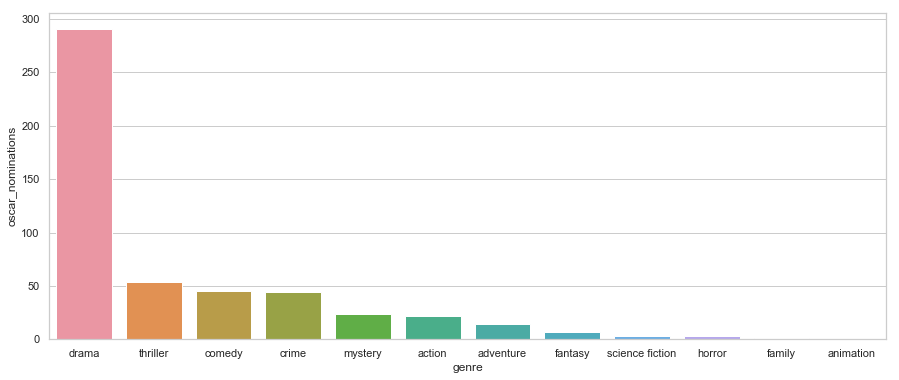

In [405]:
genres_df.sort_values(by = ['oscar_nominations'], ascending = False, inplace = True)
plt.figure(figsize = (15,6))
sns.barplot(x = 'genre', y = 'oscar_nominations', data = genres_df)
# add labels
# can I stack wins?


In [406]:
# plt.figure(figsize = (14,10))
# genres_df2 = genres_df[genres_df['oscar_nominations'] > 0]
# squarify.plot(sizes = genres_df2['oscar_nominations'], label = genres_df2['genre'])

note! The above is actually counting multiple nominations (should we do it just if nominated?). This is probably ok, though.

New Question! Maybe we can combine genres.
Are there **drama/adventure**, **drama/fantasy**, **drama/comedy** films?
Note...remember to sort by highest grossing.

In [407]:
drama_adventure = tmdb_cleaned[tmdb_cleaned['genres'].apply(lambda x: ('Drama' in x) & ('Adventure' in x))]
drama_fantasy = tmdb_cleaned[tmdb_cleaned['genres'].apply(lambda x: ('Drama' in x) & ('Fantasy' in x))]
drama_comedy = tmdb_cleaned[tmdb_cleaned['genres'].apply(lambda x: ('Drama' in x) & ('Comedy' in x))]

In [408]:
drama_adventure = drama_adventure.sort_values(by = ['revenue_adj'], ascending = False)
drama_fantasy = drama_fantasy.sort_values(by = ['revenue_adj'], ascending = False)
drama_comedy = drama_comedy.sort_values(by = ['revenue_adj'], ascending = False)

We could try exploring this data ^ by profit rather than revenue, too

In [409]:
drama_adventure.head(15)['original_title']

4413    The Twilight Saga: Breaking Dawn - Part 2
1405                  The Twilight Saga: New Moon
1959                   The Twilight Saga: Eclipse
6215                                    King Kong
8661                                    Gladiator
4374                                   Life of Pi
6969                                         Troy
629                                  Interstellar
7                                     The Martian
8664                                    Cast Away
2643                            The Mummy Returns
1394                              Sherlock Holmes
5                                    The Revenant
2880                                     Twilight
4372                  Snow White and the Huntsman
Name: original_title, dtype: object

In [410]:
drama_fantasy.head(15)['original_title']

4413    The Twilight Saga: Breaking Dawn - Part 2
1405                  The Twilight Saga: New Moon
1959                   The Twilight Saga: Eclipse
2643                            The Mummy Returns
18                                     Cinderella
2880                                     Twilight
4372                  Snow White and the Huntsman
2885          The Curious Case of Benjamin Button
2898                                    10,000 BC
6201                                  Constantine
6572                                        Click
3437                                    Immortals
1941                    The Sorcerer's Apprentice
671                                Dracula Untold
5446              The Secret Life of Walter Mitty
Name: original_title, dtype: object

In [411]:
drama_comedy.head(15)['original_title']

6224            Mr. & Mrs. Smith
1394             Sherlock Holmes
3943    My Big Fat Greek Wedding
3017            Sex and the City
6209                       Hitch
4006                     Chicago
5428     The Wolf of Wall Street
6562       The Devil Wears Prada
2640       Bridget Jones's Diary
1408                The Proposal
5003      Something's Gotta Give
4957               Love Actually
2008          Sex and the City 2
6572                       Click
6988                The Terminal
Name: original_title, dtype: object

In [412]:
drama_adventure_oscars = drama_adventure.merge(nominations, left_on = 'original_title', right_on = 'Film', how = 'inner')
drama_fantasy_oscars = drama_fantasy.merge(nominations, left_on = 'original_title', right_on = 'Film', how = 'inner')
drama_comedy_oscars = drama_comedy.merge(nominations, left_on = 'original_title', right_on = 'Film', how = 'inner')

In [413]:
drama_adventure_oscars.head(15)['original_title']

0        Gladiator
1      The Martian
2        Cast Away
3     The Revenant
4        True Grit
5    Into the Wild
6        127 Hours
7         Nebraska
Name: original_title, dtype: object

In [414]:
drama_fantasy_oscars.head(15)['original_title']

0    The Curious Case of Benjamin Button
1                       The Lovely Bones
2            Beasts of the Southern Wild
Name: original_title, dtype: object

In [415]:
drama_comedy_oscars.head(10)['original_title']

0                    Chicago
1    The Wolf of Wall Street
2      The Devil Wears Prada
3      Bridget Jones's Diary
4     Something's Gotta Give
5                       Juno
6    Silver Linings Playbook
7                   Chocolat
8            The Descendants
9               Billy Elliot
Name: original_title, dtype: object

In [416]:
print(len(drama_adventure_oscars['original_title']))
print(len(drama_fantasy_oscars['original_title']))
print(len(drama_comedy_oscars['original_title']))

8
3
25


## Microsoft -- make a drama/comedy! It's the sweet spot between making bank and oscar nods!
Great ones to model include Juno, The Wolf of Wall Street, The Devil Wears Prada, Silver Linings Playbook. All of these were high grossing films that also got oscar nominations.

#### Microsoft -- as a close second choice, make a drama/adventure film!
Great ones to model include Gladiator, The Martian, Cast Away, True Grit, Into the Wild, 127 Hours, and Cast Away. All of these were high grossing films that also got oscar nominations.

## Now we have to figure out who should direct and write the film (given a drama/comedy)

In [417]:
drama_comedy.head()

,imdb_id,popularity,budget,revenue,original_title,cast,director,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
6224,tt0356910,1.330824,110.0,478.207520,Mr. & Mrs. Smith,"[Angelina Jolie, Brad Pitt, Vince Vaughn, Adam...",Doug Liman,"[Action, Comedy, Drama, Thriller]",1750,6.5,2005,122.821962,533.948962,411.127000
1394,tt0988045,3.431559,90.0,524.028679,Sherlock Holmes,"[Robert Downey Jr., Jude Law, Rachel McAdams, ...",Guy Ritchie,"[Adventure, Drama, Action, Comedy, Thriller]",4118,6.9,2009,91.476039,532.622977,441.146938
3943,tt0259446,1.271588,5.0,368.744044,My Big Fat Greek Wedding,"[Nia Vardalos, John Corbett, Lainie Kazan, Mic...",Joel Zwick,"[Comedy, Drama, Romance]",395,6.1,2002,6.061307,447.014169,440.952862
3017,tt1000774,0.620489,65.0,415.252786,Sex and the City,"[Sarah Jessica Parker, Kim Cattrall, Cynthia N...",Michael Patrick King,"[Comedy, Drama, Romance]",309,6.1,2008,65.831131,420.562471,354.731340
6209,tt0386588,1.726470,70.0,368.100420,Hitch,"[Will Smith, Eva Mendes, Kevin James, Amber Va...",Andy Tennant,"[Comedy, Drama, Romance]",1010,6.3,2005,78.159430,411.007416,332.847986


In [418]:
directors = drama_comedy[drama_comedy['profit'] > 10].groupby('director')

In [419]:
directors_by_profit = directors.mean().sort_values(by = ['profit'], ascending = False)[:10]
directors_by_profit

,popularity,budget,revenue,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
director,,,,,,,,,
Guy Ritchie,3.431559,90.0,524.028679,4118.0,6.9,2009.0,91.476039,532.622977,441.146938
Joel Zwick,1.271588,5.0,368.744044,395.0,6.1,2002.0,6.061307,447.014169,440.952862
Doug Liman,1.330824,110.0,478.207520,1750.0,6.5,2005.0,122.821962,533.948962,411.127000
Andy Tennant,1.726470,70.0,368.100420,1010.0,6.3,2005.0,78.159430,411.007416,332.847986
Rob Marshall,0.608347,45.0,306.776732,361.0,6.5,2002.0,54.551763,371.893589,317.341826
Sharon Maguire,2.717399,25.0,281.929795,751.0,6.5,2001.0,30.787203,347.193192,316.405989
Anne Fletcher,1.895894,40.0,317.375031,1084.0,6.7,2009.0,40.656017,322.580119,281.924102
Martin Scorsese,4.877927,100.0,392.000694,4027.0,7.9,2013.0,93.603335,366.925724,273.322389
Michael Patrick King,0.802625,82.5,351.800239,292.0,5.8,2009.0,82.915566,354.455082,271.539516


In [420]:
directors_by_rating = directors.mean().sort_values(by = ['vote_average'], ascending = False)[:10]
directors_by_rating

,popularity,budget,revenue,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
director,,,,,,,,,
Martin Scorsese,4.877927,100.000000,392.000694,4027.000000,7.9,2013.0,93.603335,366.925724,273.322389
Rajkumar Hirani,0.816681,9.000000,70.000000,662.000000,7.8,2009.0,9.147604,71.148030,62.000426
Wes Anderson,2.816630,22.333333,104.768245,1485.666667,7.6,2009.0,22.896630,104.544797,81.648167
John Singleton,0.089976,16.000000,29.381649,29.000000,7.4,2001.0,19.703810,36.183152,16.479342
Richard Curtis,2.494576,20.000000,166.016108,1290.000000,7.3,2008.0,23.707053,185.929721,162.222668
John Lee Hancock,1.261132,35.000000,112.544580,811.000000,7.3,2013.0,32.761167,105.345481,72.584313
Jonathan Dayton|Valerie Faris,0.778589,8.000000,100.523181,952.000000,7.3,2006.0,8.653353,108.732825,100.079471
Marc Webb,3.244139,7.500000,60.722734,1778.000000,7.3,2009.0,7.623003,61.718613,54.095610
Martin McDonagh,1.054819,15.000000,32.002538,794.000000,7.3,2008.0,15.191800,32.411743,17.219943


for a visualization, we can plot ratings vs. profit or something like that

#### Scorsese is in both lists! But... it was only one movie (Wolf of Wall Street)

## Who should star in this film?

In [421]:
worked_with_scorsese = drama_comedy[drama_comedy['director'] == 'Martin Scorsese']['cast']
worked_with_scorsese

5428    [Leonardo DiCaprio, Jonah Hill, Margot Robbie,...
Name: cast, dtype: object

In [422]:
casts = drama_comedy[['cast', 'profit']]

In [423]:
casts_actors = casts['cast'].values 
casts_profits = casts['profit'].values

In [424]:
casts_n_profit = []
for i, actors in enumerate(casts_actors):
    to_append = (actors, casts_profits[i])
    casts_n_profit.append(to_append)


In [425]:
actors_dict = {}
for tup in casts_n_profit:
    for actor in tup[0]:
        x = str(actor)
        if x in actors_dict:
            actors_dict[x] += tup[1]/2 # this is to get the mean
        else:
            actors_dict[x] = tup[1]
    

In [426]:
sorted_actors = sorted(actors_dict.items(), key = lambda x: x[1], reverse = True)

In [432]:
actors = sorted_actors[:50] # mean revenues per actor

Maybe instead of looking at revenues I can look at popularity (whatever that column actually means)

In [433]:
actors_plot = []
revenues_plot = []
for actor in actors:
    actors_plot.append(actor[0])
    revenues_plot.append(actor[1])

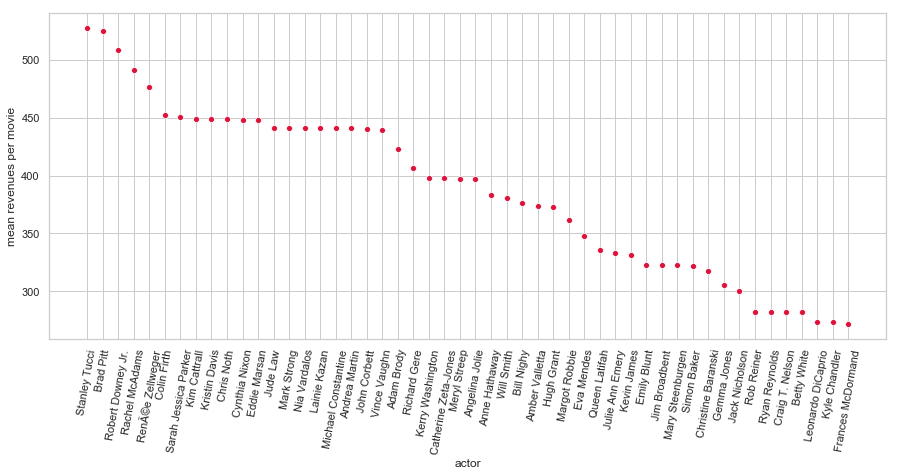

In [446]:
plt.figure(figsize = (15,6))
sns.scatterplot(x = actors_plot, y = revenues_plot, color = 'crimson')
plt.xticks(rotation=80)
plt.xlabel('actor')
plt.ylabel('mean revenues per movie')
plt.show()